<a href="https://colab.research.google.com/github/ffarishta/Satellite-Cloud-Images-Classification/blob/main/DenseNetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Concatenate, Dropout, GlobalAveragePooling2D,Conv2D
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import Sequence
from albumentations import Compose, VerticalFlip, HorizontalFlip, Rotate, GridDistortion
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback
import multiprocessing
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten

df = pd.read_csv('/content/drive/MyDrive/understanding_cloud_organization/train.csv')
num_cores = multiprocessing.cpu_count()
df = df[~df['EncodedPixels'].isnull()].copy()

df['Image'] = df['Image_Label'].map(lambda x: x.split('_')[0])
df['Class'] = df['Image_Label'].map(lambda x: x.split('_')[1])
classes = df['Class'].unique()

# Group and reset index
df = df.groupby('Image')['Class'].agg(set).reset_index()

# Add columns for each class
for class_name in classes:
    df[class_name] = df['Class'].map(lambda x: 1 if class_name in x else 0)
df.head()

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[classes])

class AlbumentationsDataGenerator(Sequence):
    def __init__(self, dataframe, directory, batch_size=32, target_size=(260, 260, 3),
                 shuffle=True, augmentation=None, class_columns=None):
        self.dataframe = dataframe.copy()
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        if class_columns is None:
            self.class_columns = dataframe.columns[2:]
        else:
            self.class_columns = class_columns
        self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / float(self.batch_size)))
    def on_epoch_end(self):
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle:
            np.random.shuffle(self.indices)
    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for i in batch_indices:
            row = self.dataframe.iloc[i]
            image = cv2.imread(os.path.join(self.directory, row['Image']))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.target_size)
            if self.augmentation:
                augmented = self.augmentation(image=image)
                image = augmented['image']
            # Convert image to float32 and normalize
            batch_images.append(image.astype('float32') / 255.0)
            # Convert label to float32
            batch_labels.append(row[self.class_columns].astype('float32'))
        return np.array(batch_images), np.array(batch_labels)

# Define the augmentation pipeline
albumentations_train = Compose([
    VerticalFlip(),
    HorizontalFlip(),
    Rotate(limit=20),
    GridDistortion()
], p=1)

In [12]:
train_dataset_path = "/content/drive/MyDrive/understanding_cloud_organization/train_images"

train_generator = AlbumentationsDataGenerator(
    dataframe=train_df,
    directory=train_dataset_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=True,
    augmentation=albumentations_train,
    class_columns=classes
)
test_generator = AlbumentationsDataGenerator(
    dataframe=test_df,
    directory=train_dataset_path,
    batch_size=32,
    target_size=(224, 224),
    shuffle=False,
    augmentation=None,
    class_columns=classes
)

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, random_state=42, test_size=0.1)

# Build the DenseNet-based model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(4, activation='sigmoid')(x)
model_densenet = Model(inputs=base_model.input, outputs=output_layer)
model_densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model_densenet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d_8 (ZeroPadd  (None, 134, 134, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d_8[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']    

In [14]:
# Train the model
history_densenet = model_densenet.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

Epoch 1/10
78/78 [==============================] - 203s 3s/step - loss: 0.8289 - accuracy: 0.3206 - val_loss: 0.8667 - val_accuracy: 0.5153
Epoch 2/10
78/78 [==============================] - 194s 2s/step - loss: 0.6980 - accuracy: 0.3675 - val_loss: 0.6911 - val_accuracy: 0.4468
Epoch 3/10
78/78 [==============================] - 202s 3s/step - loss: 0.6437 - accuracy: 0.3873 - val_loss: 0.6224 - val_accuracy: 0.3802
Epoch 4/10
78/78 [==============================] - 194s 2s/step - loss: 0.6035 - accuracy: 0.4105 - val_loss: 0.5929 - val_accuracy: 0.4018
Epoch 5/10
78/78 [==============================] - 194s 2s/step - loss: 0.5732 - accuracy: 0.4340 - val_loss: 0.6085 - val_accuracy: 0.3712
Epoch 6/10
78/78 [==============================] - 199s 3s/step - loss: 0.5543 - accuracy: 0.4464 - val_loss: 0.5867 - val_accuracy: 0.3838
Epoch 7/10
78/78 [==============================] - 197s 3s/step - loss: 0.5363 - accuracy: 0.4572 - val_loss: 0.5939 - val_accuracy: 0.3766
Epoch 8/10
78

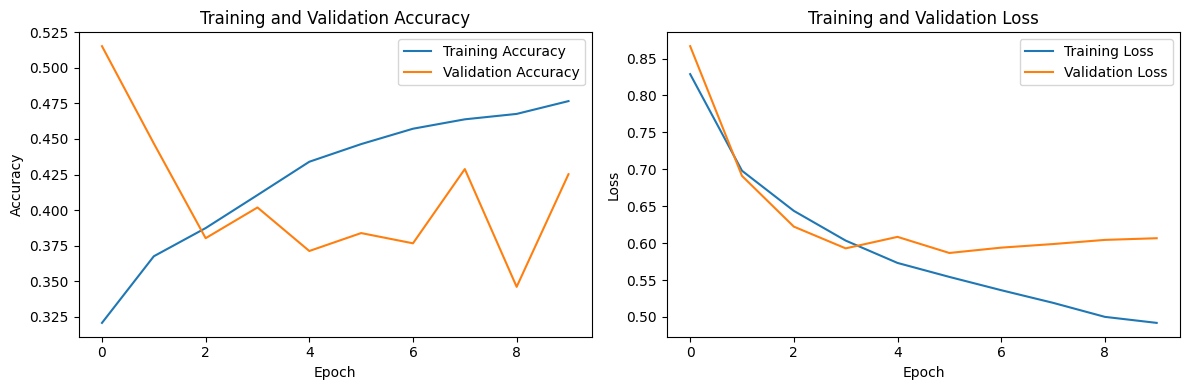

In [15]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Data generator for training
train_generator = AlbumentationsDataGenerator(
    dataframe=train_df,
    directory=train_dataset_path,
    batch_size=32,
    target_size=(128, 128),
    shuffle=True,
    augmentation=albumentations_train,
    class_columns=classes
)

# Data generator for testing
test_generator = AlbumentationsDataGenerator(
    dataframe=test_df,
    directory=train_dataset_path,
    batch_size=32,
    target_size=(128, 128),
    shuffle=False,
    augmentation=None,
    class_columns=classes
)

# Train the model using the generators
history_densenet = model_densenet.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    workers=num_cores,
    use_multiprocessing=True
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_densenet.evaluate(test_generator, workers=num_cores, use_multiprocessing=True)

# Print accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10
139/139 [==============================] - 343s 2s/step - loss: 0.5801 - accuracy: 0.4143 - val_loss: 0.5645 - val_accuracy: 0.4288
Epoch 2/10
139/139 [==============================] - 343s 2s/step - loss: 0.5751 - accuracy: 0.4089 - val_loss: 0.5703 - val_accuracy: 0.4703
Epoch 3/10
139/139 [==============================] - 352s 3s/step - loss: 0.5792 - accuracy: 0.4119 - val_loss: 0.5641 - val_accuracy: 0.4036
Epoch 4/10
139/139 [==============================] - 347s 2s/step - loss: 0.5776 - accuracy: 0.4209 - val_loss: 0.5696 - val_accuracy: 0.4766
Epoch 5/10
139/139 [==============================] - 350s 2s/step - loss: 0.5766 - accuracy: 0.4141 - val_loss: 0.5673 - val_accuracy: 0.4189
Epoch 6/10
139/139 [==============================] - 347s 2s/step - loss: 0.5792 - accuracy: 0.4116 - val_loss: 0.5685 - val_accuracy: 0.4108
Epoch 7/10
139/139 [==============================] - 351s 2s/step - loss: 0.5773 - accuracy: 0.4101 - val_loss: 0.5740 - val_accuracy: 0.4595